In [3]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fnmatch
import matplotlib.ticker as ticker

In [4]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [5]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.ConfigFileUtils import ConfigFileUtils

Welcome to JupyROOT 6.10/09


Using TensorFlow backend.


In [6]:
bin_dir = {"Untagged": 0,
            "VBF1j": 1,
            "VBF2j": 2,
            "VHlept": 3,
            "VHhadr": 4,
            "ttHlept": 5,
            "ttHhadr": 6,
            "VHMET": 7}

In [7]:
campaign_workspace = "/data_CMS/cms/wind/"
campaign_names = ["180409_MC_weighting_Adam", "180409_no_MC_weights_Adam", "180409_no_MC_weights_Adam_smallbatch", "180406_MC_weighting_Adam", "180406_no_MC_weighting_Adam", "180406_MC_weighting_SGD", "180406_no_MC_weighting_SGD", "180408_no_weights_oldtraining"]

In [8]:
def make_comparison_plot(campaign_workspace, campaign_names, identifier):
    df = pd.DataFrame()

    for campaign_name in campaign_names:
        campaign_dir = campaign_workspace + campaign_name + "/"
    
        for folder, subs, files in os.walk(campaign_dir):
            if fnmatch.fnmatch(folder, identifier):
                values = {}
            
                punzi_file = folder + "/Mor18_punzi_comp.conf"
            
                try:                
                    # try to read the punzi values
                    conf = ConfigFileHandler()
                    conf.load_configuration(punzi_file)
                    
                    # load the Punzi values for each category
                    for category, bin_number in bin_dir.iteritems():
                        values[category] = [float(conf.get_field("Punzi", category))]
            
                    benchmark_value = values['VBF1j'][0] + values['VBF2j'][0] + values['VHlept'][0] + values['VHhadr'][0] + values['ttHlept'][0] + values['ttHhadr'][0] + values['VHMET'][0] - 7
            
                    values["campaign"] = folder.replace(campaign_workspace, '') + ' (' + str(benchmark_value) + ')'
                    values["benchmark_value"] = benchmark_value
            
                    df = df.append(pd.DataFrame.from_dict(values))
                except (KeyError, IOError):
                    print(punzi_file + " does not exist")
                    
    df = df.sort_values('benchmark_value', ascending = False)
                
    sorted_datacols = sorted(bin_dir.items(), key = lambda x: x[1])
    sorted_datacol_names = [x[0] for x in sorted_datacols]
    
    punzi_data = df[sorted_datacol_names].as_matrix()
    punzi_data = np.transpose(punzi_data)
    
    inparam_labels = np.concatenate([[''], df['campaign'].as_matrix()])
        
    fig = plt.figure(figsize = (15, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(punzi_data, interpolation = 'none', cmap = 'RdYlGn', aspect = 0.6, vmin = 0.8, vmax = 1.2)
    fig.colorbar(cax)
    #ax.set_yticklabels(range(len(bin_dir)), [''] + sorted_datacol_names)
    #ax.set_xticklabels(range(len(df)), inparam_labels, rotation = 'vertical')
    ax.set_yticklabels([''] + sorted_datacol_names)
    ax.set_xticklabels(inparam_labels, rotation = 'vertical')
    ax.xaxis.tick_bottom()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.tight_layout()
    plt.title("Punzi purity ratio")
    #plt.savefig(statistics_dir + "punzi_input_sweep.pdf")
    #plt.show()
    
    return fig

In [27]:
%%capture
plot_14 = make_comparison_plot(campaign_workspace, ["180414_class_weights_Adam_smallbatch_reanalysis"], "*comp*")

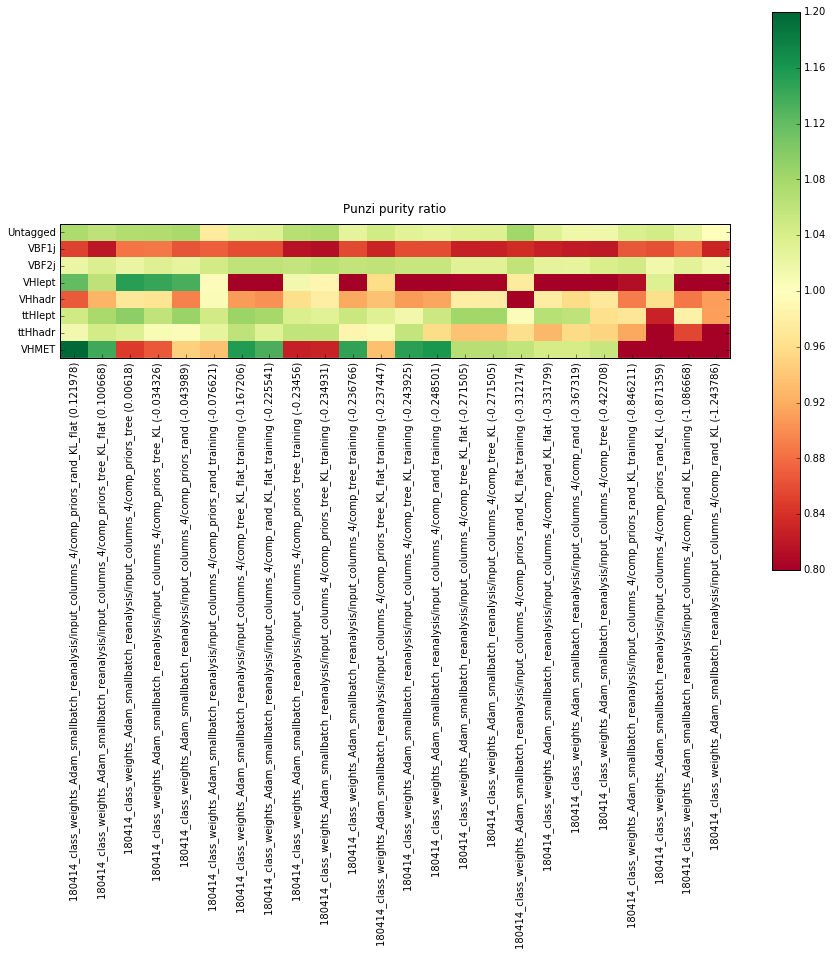

In [28]:
plt.show()

In [29]:
%%capture
plot_14 = make_comparison_plot(campaign_workspace, ["180414_class_weights_Adam_largebatch_reanalysis"], "*comp*")

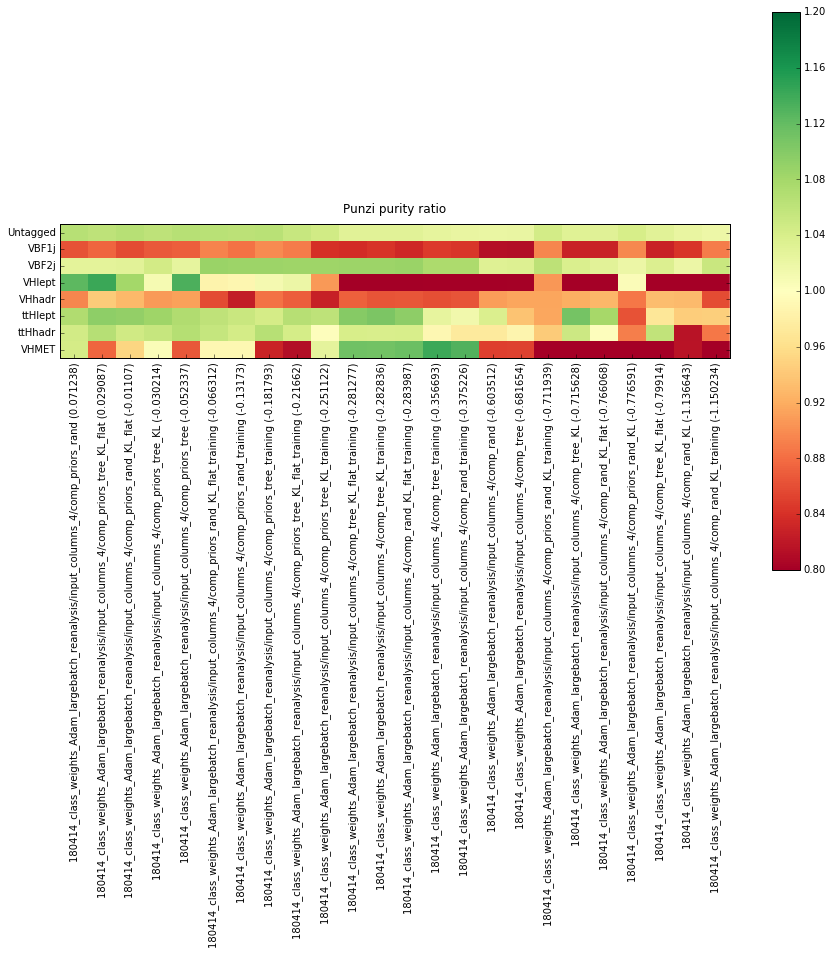

In [30]:
plt.show()

In [31]:
%%capture
plot_14 = make_comparison_plot(campaign_workspace, ["180414_class_weights_RMSprop_smallbatch_reanalysis"], "*comp*")

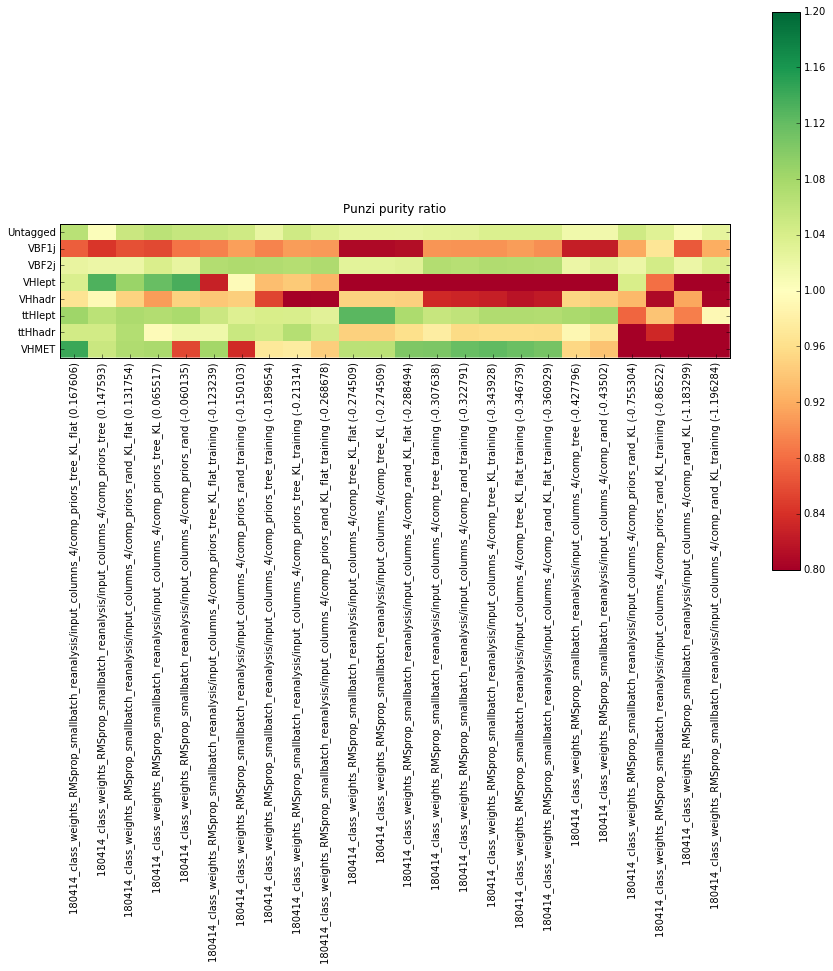

In [32]:
plt.show()

In [33]:
%%capture
plot_14 = make_comparison_plot(campaign_workspace, ["180414_no_weights_RMSprop_smallbatch_reanalysis"], "*comp*")

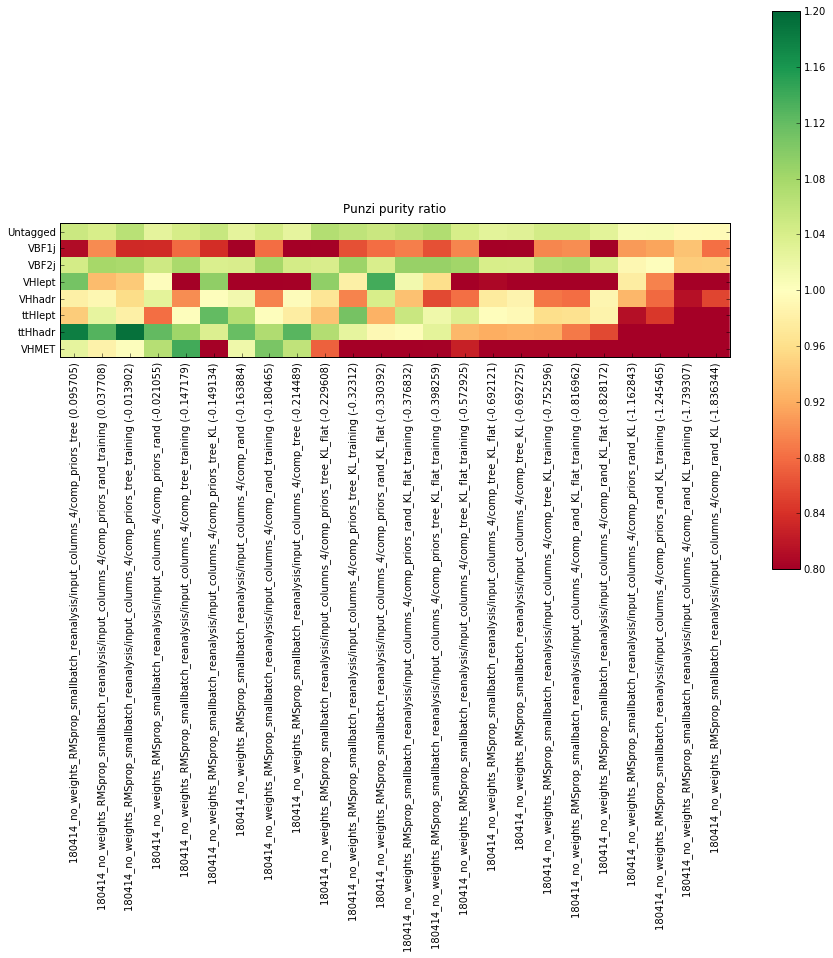

In [34]:
plt.show()